In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, Reshape, Lambda, Subtract
from keras.layers import GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation
from keras import backend as K

import params

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
descriptor_size = 512

In [3]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))  # 1e-07


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)  # (None, 1)

In [4]:
def merge_imgs_channels(img1, img2):
    b1,g1,r1 = cv2.split(img1)
    b2,g2,r2 = cv2.split(img2)
    
    return cv2.merge([b1,g1,r1, b2,g2,r2])

In [5]:
def crop(dimension):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[:,:,:,0:3]
        if dimension == 1:
            return x[:,:,:,3:6]
    return Lambda(func)


def BaseModel(input_shape, name='encoder'):
    inp = Input(shape=input_shape)

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(256, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)
    
    flat_1 = Flatten()(pool_3)
    descriptor = Dense(descriptor_size, name='descriptor')(flat_1)
    
    return Model(inputs=inp, outputs=descriptor, name=name)

def GetEncoder(siamese_ae_model):
    return Model(
        inputs=siamese_ae_model.get_layer('encoder').get_input_at(0), 
        outputs=siamese_ae_model.get_layer('encoder').get_output_at(0))

def BuildModel_AE(input_shape):
    base_network = BaseModel(input_shape, 'encoder')

    new_input_shape = (input_shape[0], input_shape[1], 2 * input_shape[2])
    double_input = Input(shape=new_input_shape, name='input_1')
    
    input_a = crop(0)(double_input)
    input_b = crop(1)(double_input)

    processed_a = base_network(input_a)
#     processed_a.set_name('descriptor0')
    processed_b = base_network(input_b)
#     processed_b.name = 'descriptor1'

#     print(processed_a, type(processed_a))

    value_a = Lambda(lambda x : x, output_shape=list(processed_a.shape), name='value_a')(processed_a)
    value_b = Lambda(lambda x : x, output_shape=list(processed_b.shape), name='value_b')(processed_b)

#     distance = Subtract()([value_a, value_b])
    
    distance = Subtract()([processed_a, processed_b])

    return Model(double_input, distance)

best_w = keras.callbacks.ModelCheckpoint('siamese_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('siamese_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]
# callbacks = None

model_input_shape = (params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum())
model = BuildModel_AE( model_input_shape )
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'mse')

In [6]:
model1 = BaseModel(model_input_shape, )

input_sample = np.ones(model_input_shape).astype(np.float32)
input_sample = np.expand_dims(merge_imgs_channels(input_sample, input_sample), axis=0)
result = model.predict(input_sample)
print(input_sample.shape)

result = model.predict(input_sample)
result = np.squeeze(result, axis=0)

print(input_sample.shape, result.shape)

# model1.save('test.h5')

(1, 256, 256, 6)
((1, 256, 256, 6), (512,))


In [7]:
# model.summary()

a = model.get_layer('encoder').get_input_at(0)
b = model.get_layer('encoder').get_output_at(0)

intermediate_layer_model = Model(inputs=a, outputs=b)
# intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('encoder_12').get_output_at(0))

# intermediate_layer_model.summary()

# model.save('test.h5')

In [8]:
input_sample = np.ones(model_input_shape).astype(np.float32)
input_sample = np.expand_dims(merge_imgs_channels(input_sample, input_sample), axis=0)
result = model.predict(input_sample)


result = model.predict(input_sample)
print(input_sample.shape, result.shape)
print(type(input_sample))

# model.save('test.h5')

((1, 256, 256, 6), (1, 512))
<type 'numpy.ndarray'>


In [9]:
import cv2
import numpy as np
import os, shutil
import glob
import random

def GenerateImage(image, sample_width, sample_height, use_scaling):
    height, width, _ = image.shape
    
    scale = random.uniform(0.9, 2) if use_scaling else 1
    
    scaled_sample_width = int(round(sample_width))
    scaled_sample_height = int(round(sample_height))
    
    x_offset = random.randint(0, width - scaled_sample_width - 1)
    y_offset = random.randint(0, height - scaled_sample_height - 1)

    sample = image[y_offset:y_offset + scaled_sample_height, x_offset:x_offset + scaled_sample_width]
    sample = cv2.resize(sample, (sample_width, sample_height))
    
    angles = [0, 90, 180, 270]
    angle = random.choice(angles)
    if angle > 0:
        for i in range(int(angle / 90)):
            sample = np.rot90(sample)
    
    return sample

def get_class_from_filename(filename):
    return int(os.path.basename(filename)[0])

def keras_generator_test(basepath, batch_size, use_merging=False, use_scaling=True, class_template=''):
    origin_img_files = glob.glob(os.path.join(basepath, class_template + '*.*'))
    
    origin_imgs = [ cv2.imread(img_name, cv2.IMREAD_COLOR) for img_name in origin_img_files ]
    
    index = 0

    while True:
        x_batch = []
        
        for i in range(batch_size):
            index1 = random.randint(0, len(origin_imgs) - 1)            
            img1 = GenerateImage(origin_imgs[index1], params.GetImageSize(), params.GetImageSize(), use_scaling)

            merged = merge_imgs_channels(img1, img1) if use_merging else img1
            
            #x_batch += [ np.expand_dims(merged, axis=0) ]
            x_batch += [ merged ]
            

        yield np.array(x_batch)
        
def keras_generator(basepath, batch_size, use_scaling=True, class_template=''):
    origin_img_files = glob.glob(os.path.join(basepath, class_template + '*.*'))
    
    origin_imgs = [ cv2.imread(img_name, cv2.IMREAD_COLOR) for img_name in origin_img_files ]
    
    index = 0
    
    
    
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            index1 = random.randint(0, len(origin_imgs) - 1)            
            img1 = GenerateImage(origin_imgs[index1], params.GetImageSize(), params.GetImageSize(), use_scaling)

            index2 = random.randint(0, len(origin_imgs) - 1)            
            img2 = GenerateImage(origin_imgs[index2], params.GetImageSize(), params.GetImageSize(), use_scaling)

            class1 = get_class_from_filename(origin_img_files[index1])
            class2 = get_class_from_filename(origin_img_files[index2])
            requested_output = 1 if class1 == class2 else 0

            merged = merge_imgs_channels(img1, img2)
            
            #x_batch += [ np.expand_dims(merged, axis=0) ]
            x_batch += [ merged ]
            y_batch += [[descriptor_size * requested_output] * descriptor_size]
            
#             print(class1,class2,requested_output)
            

        yield np.array(x_batch), np.array(y_batch)
        #yield x_batch[0], y_batch[0]

In [10]:
batch_size = 8

In [11]:
for x,y in keras_generator('./imgs_classified_reduced', batch_size):
    break
print(np.array(x).shape, np.array(y).shape)

((8, 256, 256, 6), (8, 512))


In [12]:
type(x)

numpy.ndarray

In [13]:
result = model.predict(x)
print(result.shape)

(8, 512)


In [14]:
history = model.fit_generator(keras_generator('./imgs_classified_reduced', batch_size),
              steps_per_epoch=15,
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator('./imgs_classified_reduced', batch_size),
              validation_steps=3,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5
15/15 [==============================] - 96s 6s/step - loss: 94559.6716 - val_loss: 75435.4961
Epoch 2/5
15/15 [==============================] - 89s 6s/step - loss: 91768.3126 - val_loss: 108910.7578
Epoch 3/5
15/15 [==============================] - 83s 6s/step - loss: 63328.2450 - val_loss: 54770.7096
Epoch 4/5
15/15 [==============================] - 83s 6s/step - loss: 84967.3713 - val_loss: 109417.9609
Epoch 5/5
15/15 [==============================] - 83s 6s/step - loss: 93511.3271 - val_loss: 161567.1146


['loss', 'val_loss']


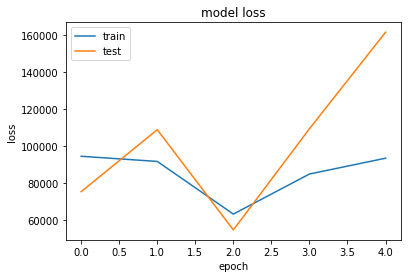

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
model1=model
model = None

In [17]:
from keras.models import load_model
model1 = load_model('siamese_best.h5')

In [18]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 6)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
encoder (Model)                 (None, 512)          134652832   lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [19]:
intermediate_layer_model = GetEncoder(model1)

# intermediate_layer_model = Model(inputs=model1.input, outputs=model1.get_layer('value_a').get_output_at(0))
#intermediate_layer_model = Model(inputs=model1.input, outputs=model1.get_output_at(3).output)

In [20]:
testing_batch_size = 16

for x in keras_generator_test('./imgs_classified_reduced', testing_batch_size, use_scaling=False, use_merging=False):
    break
intermediate_output = intermediate_layer_model.predict(x)
print(x.shape, intermediate_output.shape)

((16, 256, 256, 3), (16, 512))


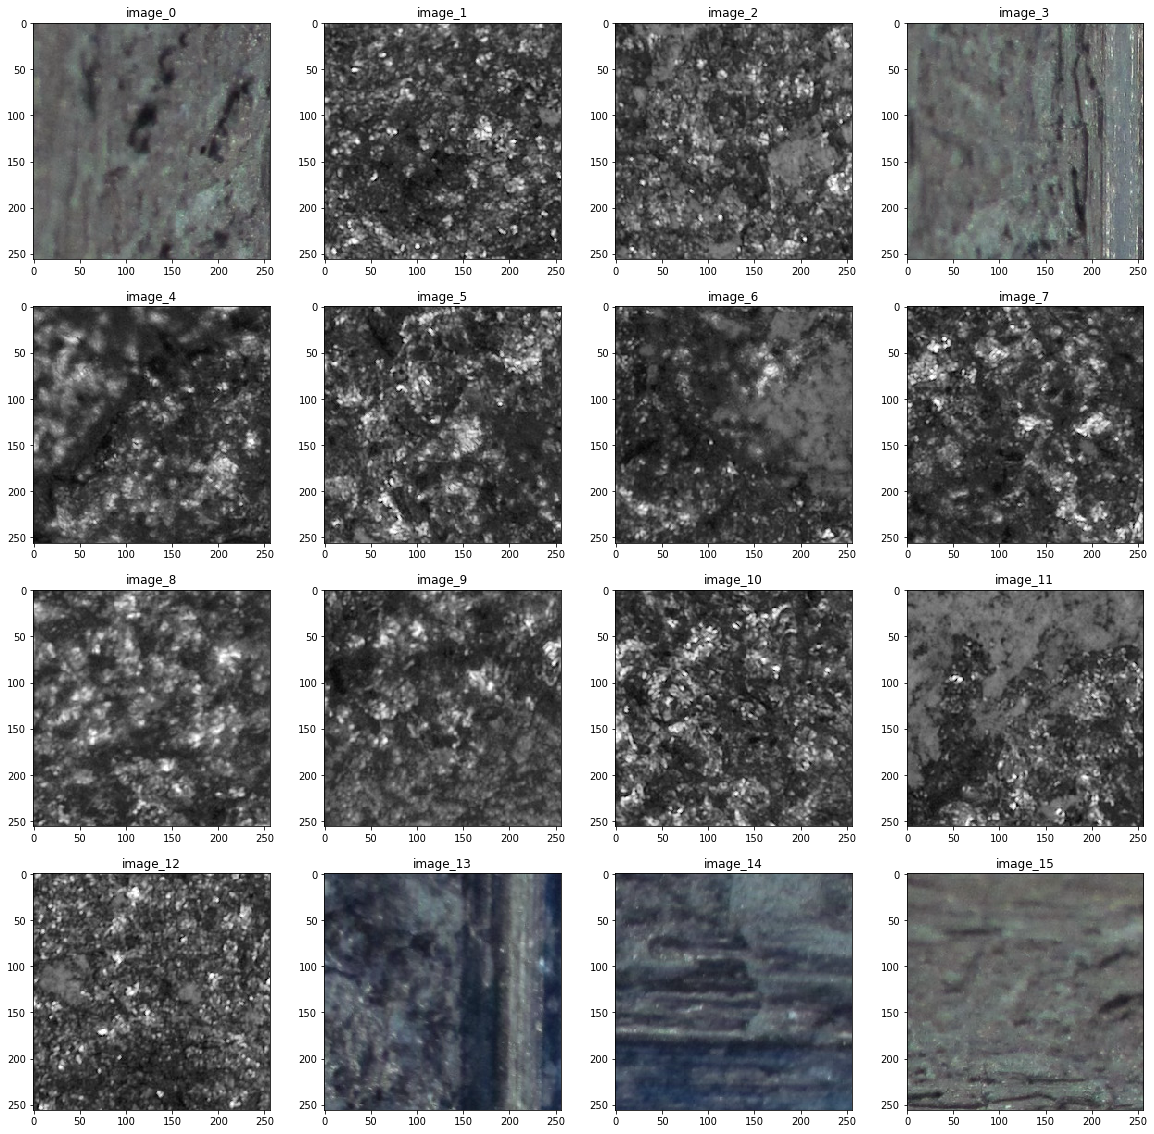

In [21]:
import matplotlib.pyplot as plt

data_count = x.shape[0]

fig, axes = plt.subplots(nrows=int(data_count/4), ncols=4, figsize=(20, 20))
for i in range(data_count):
    row = int(i / 4)
    col = int(i % 4)
    axes[row][col].imshow(x[i, :, :, 0:3])
    axes[row][col].set_title('image_' + str(i))
    #axes[i][1].plot(intermediate_output[i,:])


# axes[0][0].imshow(x[0, :, :, :])
# axes[1][0].imshow(x[1, :, :, :])
# axes[2][0].imshow(x[2, :, :, :])
# axes[3][0].imshow(x[3, :, :, :])

# #plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
# axes[0][1].plot(intermediate_output[0,:], 'r')
# axes[1][1].plot(intermediate_output[1,:], 'b')
# axes[2][1].plot(intermediate_output[2,:], 'g')
# axes[3][1].plot(intermediate_output[3,:], 'k')

plt.show()

In [22]:
in_data = intermediate_output.transpose()
mean, eigenvectors = cv2.PCACompute(in_data, np.mean(in_data, axis=0).reshape(1,-1), maxComponents=2)

In [23]:
mean, eigenvectors

(array([[-11.063772, -14.501786, -14.081938, -14.531349, -10.813453,
         -14.067688, -10.319925, -10.741299, -15.065456, -12.061993,
         -11.8403  , -16.426186, -12.187515,  -9.181649,  -9.537586,
         -11.636306]], dtype=float32),
 array([[ 2.5941864e-01,  2.5122654e-01,  2.7153230e-01,  2.8832421e-01,
          2.2233549e-01,  2.4637930e-01,  2.0407307e-01,  2.4500374e-01,
          2.5143567e-01,  2.4464977e-01,  2.7806497e-01,  2.6402786e-01,
          2.7587283e-01,  2.1560043e-01,  2.0644237e-01,  2.5613701e-01],
        [-7.9865724e-02, -6.5821461e-02,  2.6931811e-02, -1.0456264e-01,
         -4.1493997e-01,  8.1433797e-01,  8.4560752e-02, -3.3227357e-01,
          7.5883165e-02,  2.1875387e-02,  5.3666025e-02, -9.3112469e-02,
          6.3873805e-02,  4.9580424e-04, -4.5849804e-02, -2.7997471e-02]],
       dtype=float32))

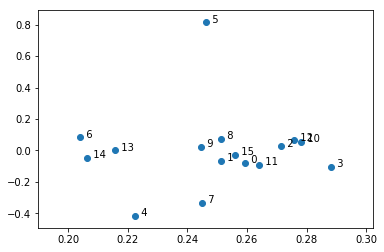

In [24]:
eigenvectors[:,0]
view_data = eigenvectors

fig, ax = plt.subplots()
ax.scatter(view_data[0,:], view_data[1,:])

for i in range(len(view_data[0,:])):
    ax.annotate('  ' + str(i), (view_data[0,:][i], view_data[1,:][i]))

plt.show()

In [26]:
testing_batch_size = 16

classes_num = 3
classified_data = np.zeros((testing_batch_size * classes_num, descriptor_size)).astype(np.float32)

samples = []

for class_idx in range(classes_num):
    for x in keras_generator_test('./imgs_classified_reduced', testing_batch_size, use_scaling=False, use_merging=False, class_template=str(class_idx)):
        break
    sp = testing_batch_size * class_idx
    tp = testing_batch_size * (class_idx + 1)
    classified_data[sp:tp] = intermediate_layer_model.predict(x)
    samples.append(x[:, :, :, 0:3])


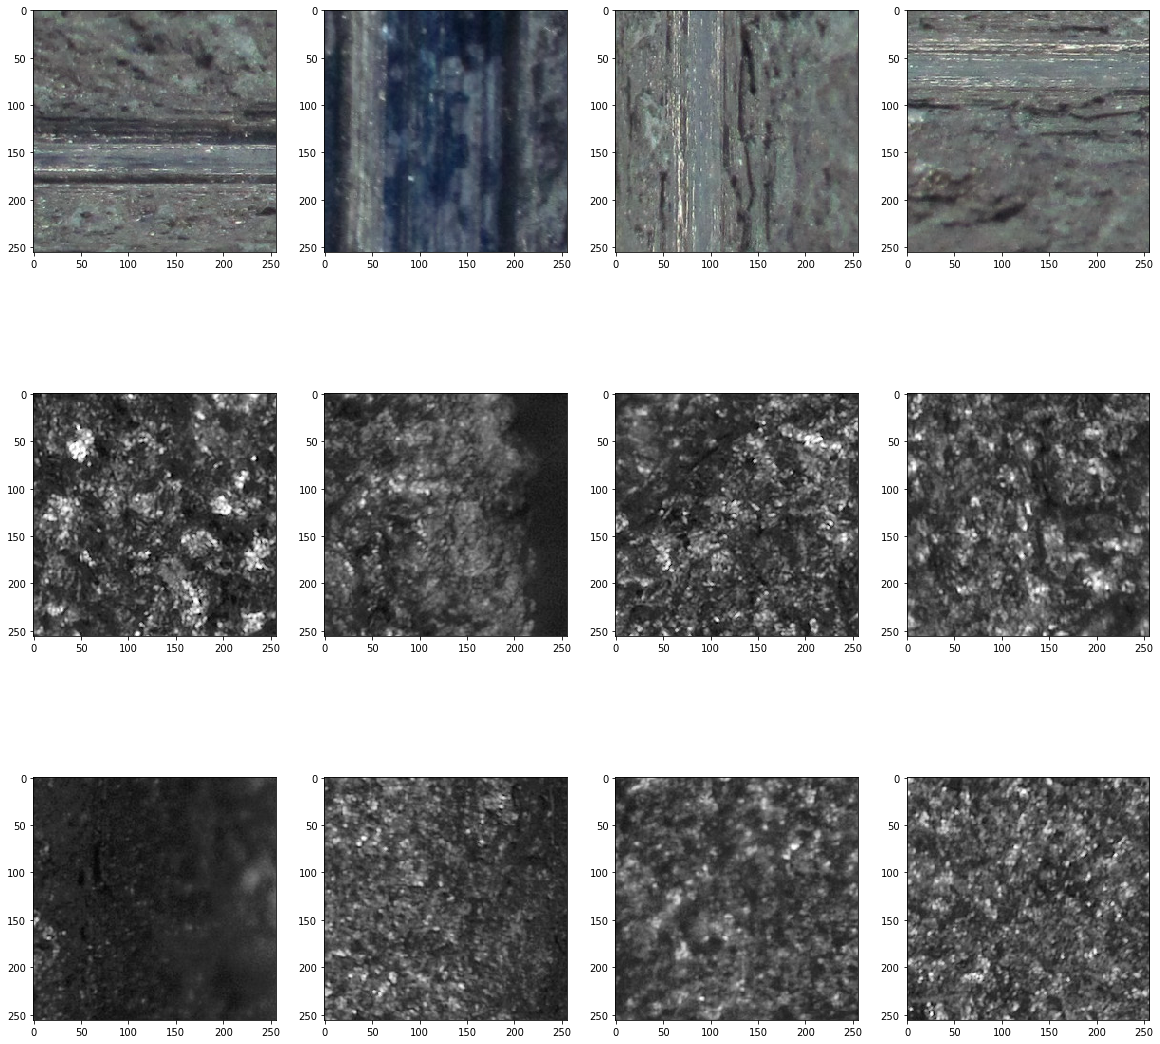

In [27]:
data_count = classified_data.shape[0]

fig, axes = plt.subplots(nrows=int(classes_num), ncols=4, figsize=(20, 20))
for row in range(classes_num):
    for col in range(4):
        axes[row][col].imshow(samples[row][col, :, :, :])
    
plt.show()

In [28]:
in_data = classified_data.transpose()
mean, eigenvectors = cv2.PCACompute(in_data, np.mean(in_data, axis=0).reshape(1,-1), maxComponents=2)


In [29]:
eigenvectors.shape

(2, 48)

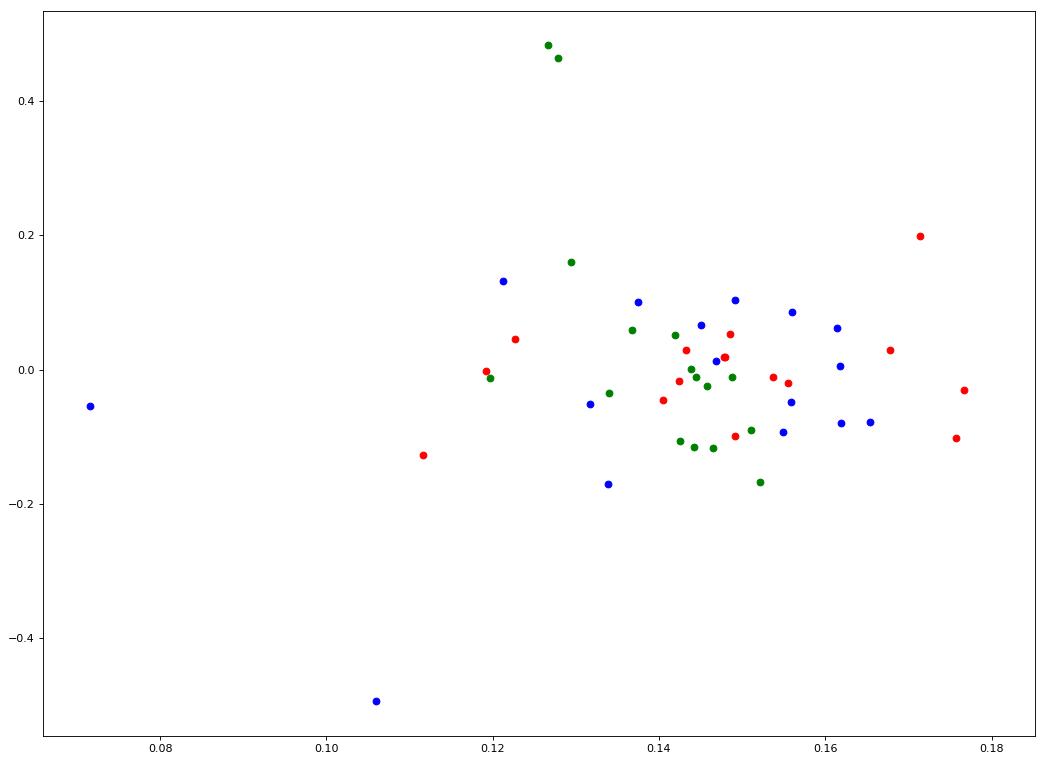

In [30]:
view_data = eigenvectors

fig, ax = plt.subplots(figsize=(16, 12), dpi=80)

colors = ['red', 'green', 'blue', 'magenta', 'black', 'cyan', 'yellow', 'gray', 'brown', 'orange']
for class_idx in range(classes_num):
    sp = testing_batch_size * class_idx
    tp = testing_batch_size * (class_idx + 1)
    ax.scatter(view_data[0,sp:tp], view_data[1,sp:tp], c=colors[class_idx])

plt.show()

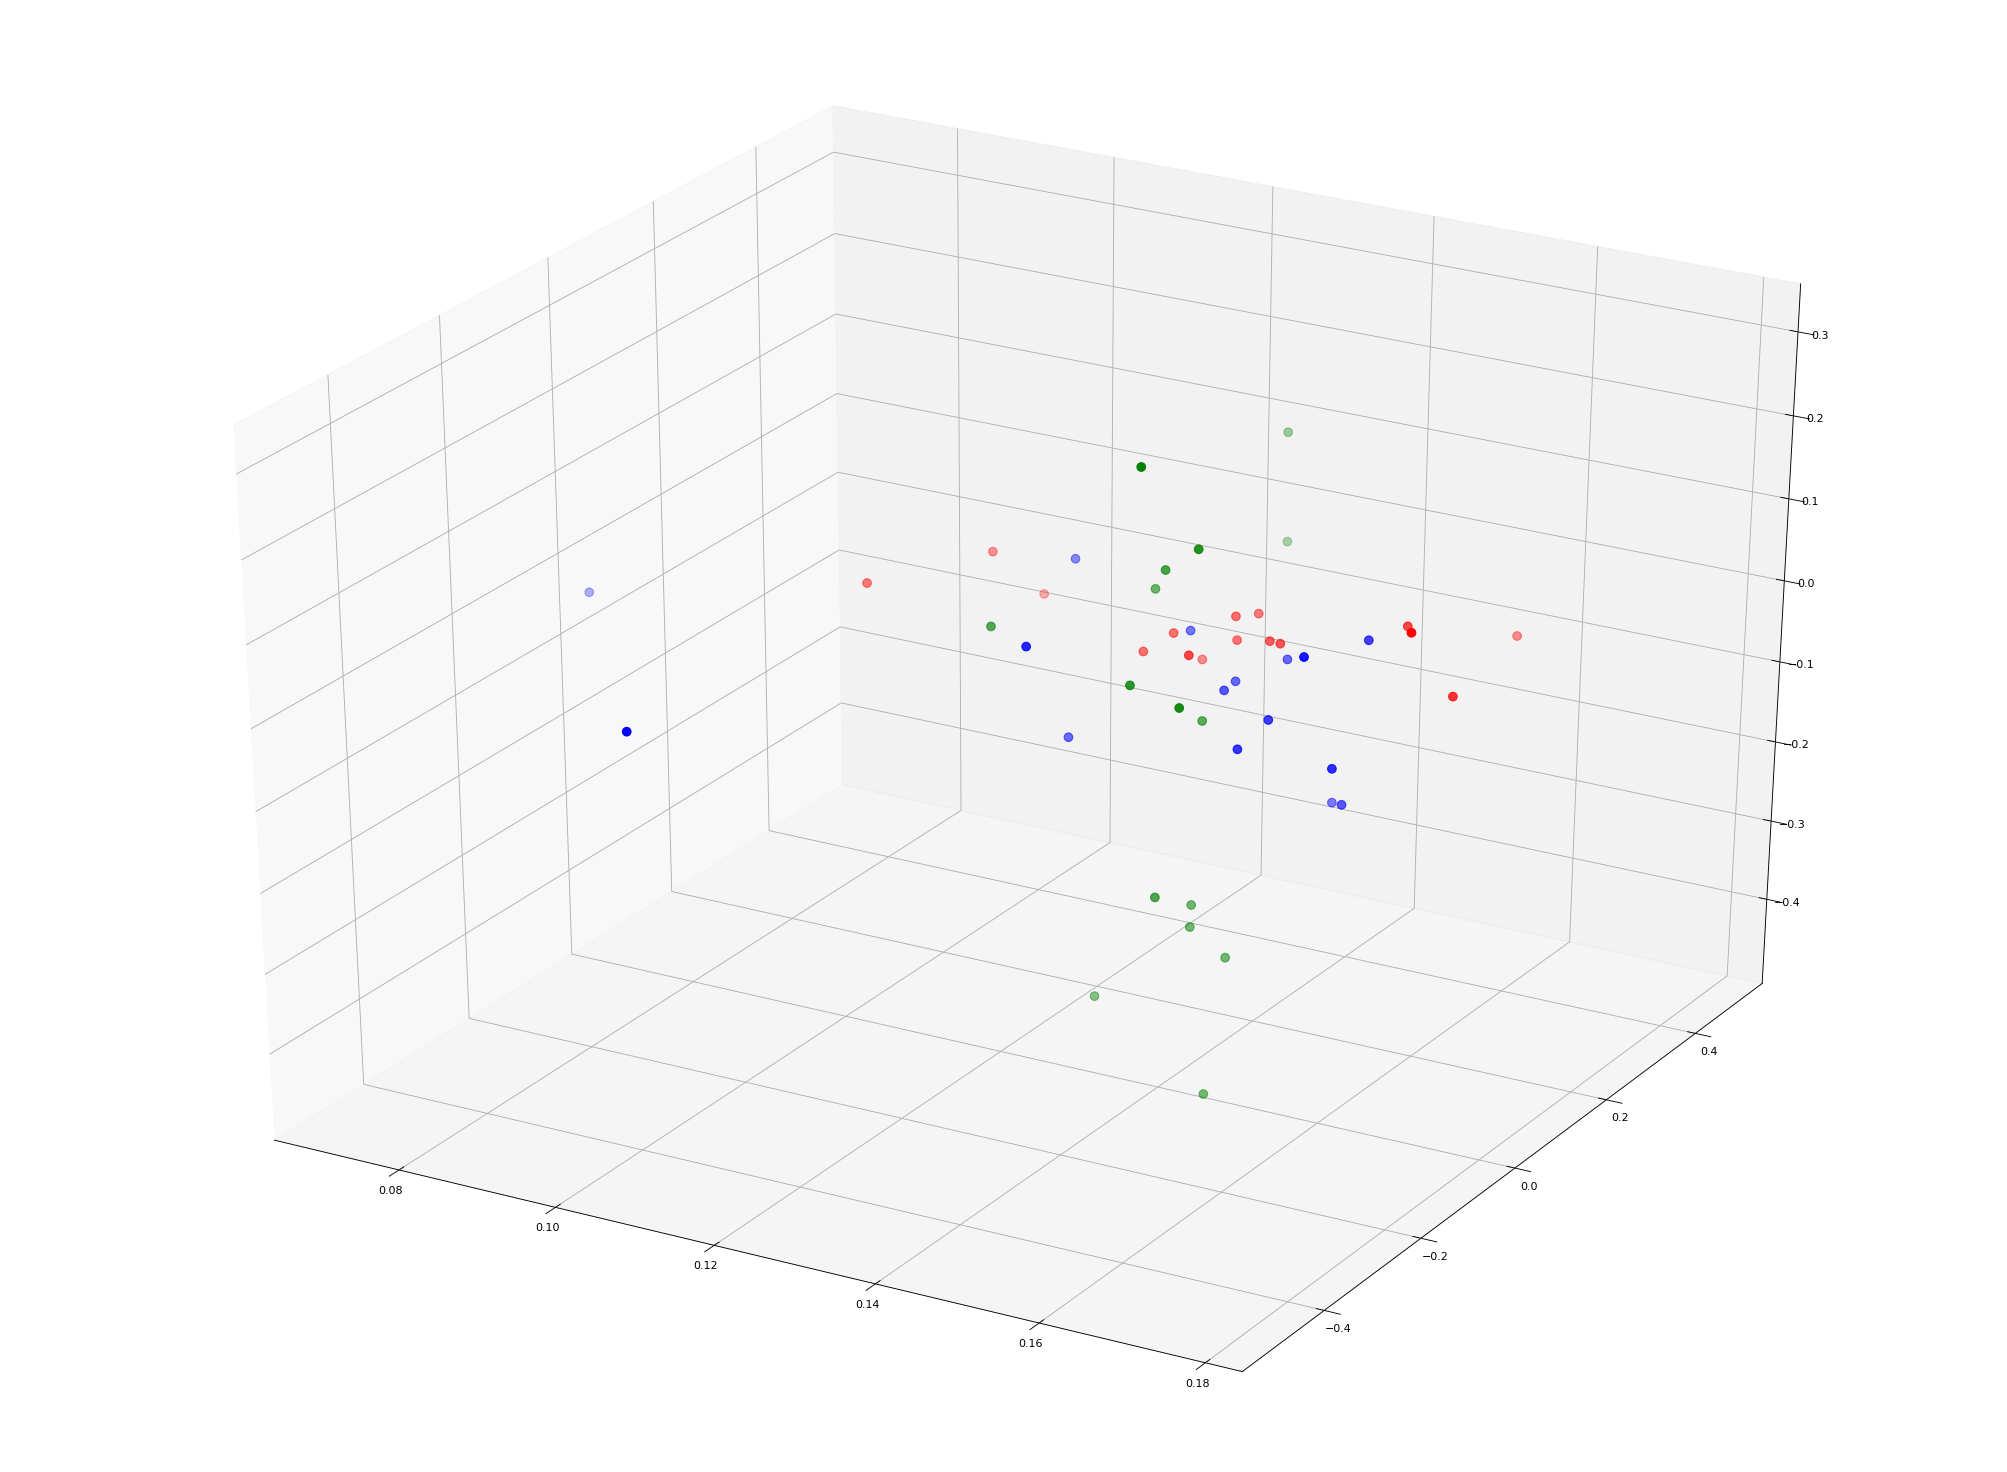

In [31]:
from mpl_toolkits.mplot3d import Axes3D 
# %matplotlib
%matplotlib inline

in_data3 = classified_data.transpose()
mean3, eigenvectors3 = cv2.PCACompute(in_data, np.mean(in_data, axis=0).reshape(1,-1), maxComponents=3)

view_data = eigenvectors3

fig = plt.figure(figsize=(32, 24), dpi=80)
# fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'magenta', 'black', 'cyan', 'yellow', 'gray', 'brown', 'orange']
for class_idx in range(classes_num):
    sp = testing_batch_size * class_idx
    tp = testing_batch_size * (class_idx + 1)
    ax.scatter(view_data[0,sp:tp], view_data[1,sp:tp], view_data[2,sp:tp], c=colors[class_idx], s=60)

plt.show()
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

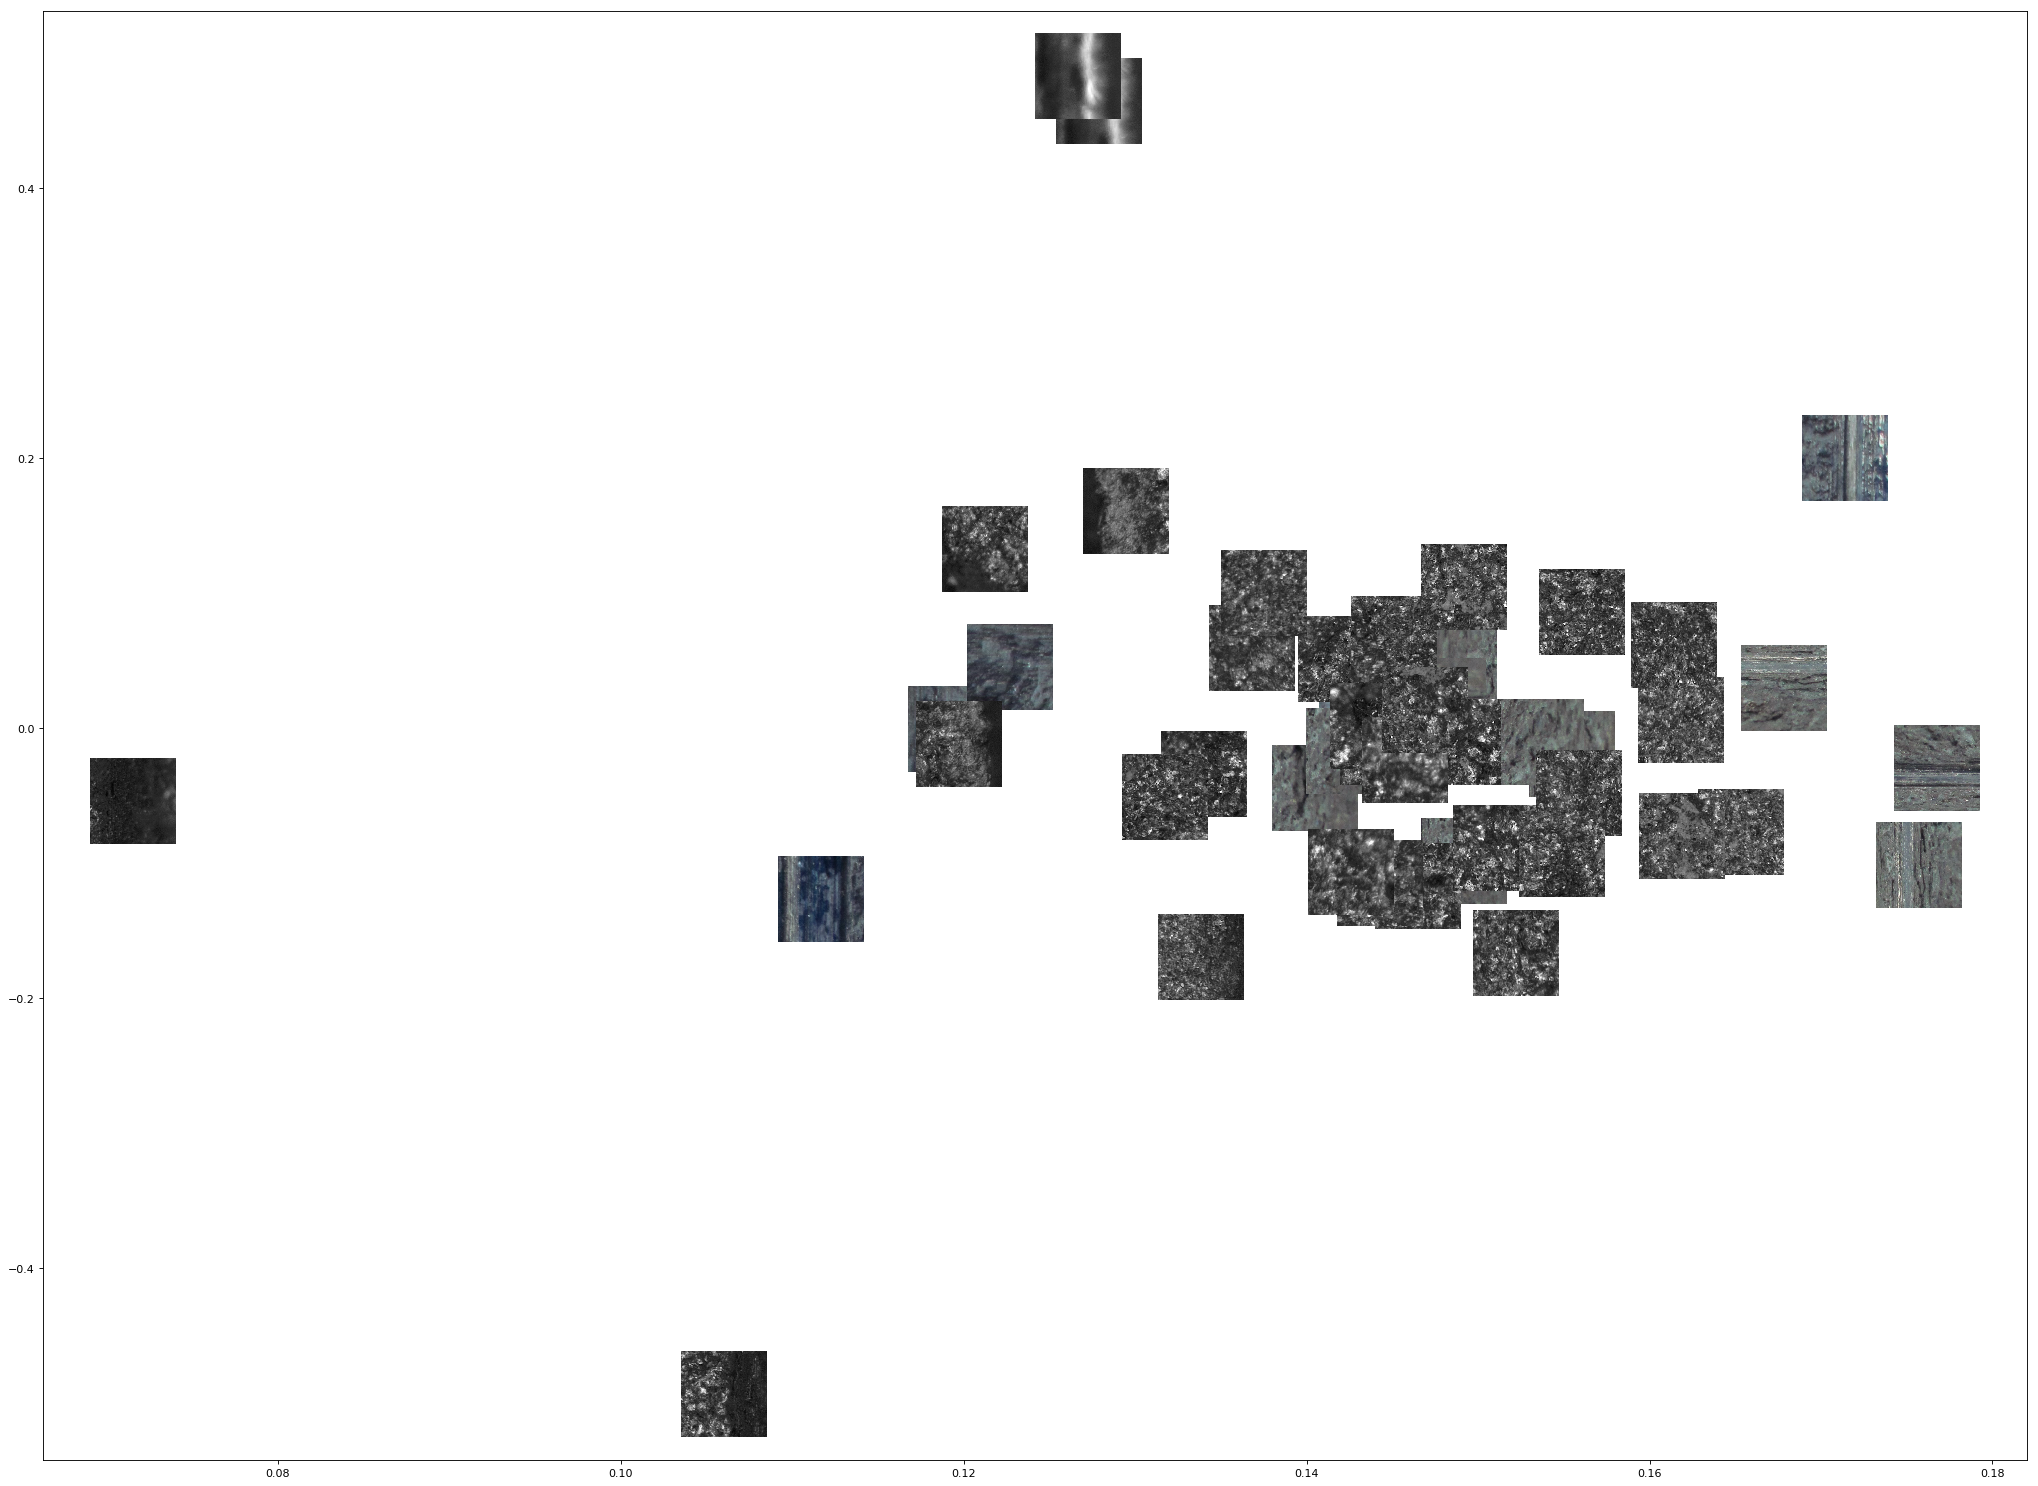

In [32]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

view_data = eigenvectors

fig, ax = plt.subplots(figsize=(32, 24), dpi=80)

# colors = ['red', 'green', 'blue', 'magenta', 'black']
# for class_idx in range(classes_num):
#     sp = testing_batch_size * class_idx
#     tp = testing_batch_size * (class_idx + 1)
#     ax.scatter(view_data[0,sp:tp], view_data[1,sp:tp], c=colors[class_idx])
    
zoom = 0.3
for row in range(classes_num):
    for col in range(testing_batch_size):
        im = OffsetImage(samples[row][col, :, :, :], zoom=zoom)
        sp = testing_batch_size * row + col
        ab = AnnotationBbox(im, (view_data[0,sp], view_data[1,sp]), xycoords='data', frameon=False)
        ax.add_artist(ab)
ax.update_datalim(np.column_stack([view_data[0,:], view_data[1,:]]))
ax.autoscale()

plt.show()